# Preparing the Dataset

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)

In [24]:
# Dropping all of the columns which we will not use
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64'}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC.describe()
listingsNYC['annual_revenue'] = (365 - listingsNYC['availability_365']) *  listingsNYC['price']
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC.loc[:,'log_pps']=np.log(listingsNYC['pps'])
listingsNYC.loc[:,'is_budget'] = listingsNYC['log_pps'].apply(lambda x: x < 6.69864257)
listingsNYC.loc[:,'is_luxury'] = listingsNYC['log_pps'].apply(lambda x: x > 6.69864257)
# listingsNYC['price_bin'] = pd.cut(listingsNYC['price'], bins=range(0, 111, 10), right=False, labels=range(0, 110, 10))

In [25]:
df = listingsNYC[(listingsNYC['price']<2000) & (listingsNYC['price']>20) & (listingsNYC['minimum_nights'] < 30)]

In [26]:
df['price_bin'] = pd.cut(df['price'], bins=range(0, 2001, 20), right=False, labels=range(0, 2000, 20))

In [27]:
price_bin_grouping_mean = df.groupby('price_bin').mean()
price_bin_grouping_count = df.groupby('price_bin').count()
price_bin_grouping_count = price_bin_grouping_count[['price']]
price_bin_grouping_count.rename(columns={'price':'price_bin_count'}, inplace=True)
price_bin_grouping = pd.merge(price_bin_grouping_mean,price_bin_grouping_count, how = 'left', on= 'price_bin')
price_bin_grouping

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,annual_revenue,log_price,log_pps,is_budget,is_luxury,price_bin_count
price_bin,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
20,34.215517,5.400862,31.560345,1.259948,15.603448,107.159483,8.323276,182.715517,8761.159483,3.526285,4.599573,0.948276,0.051724,232
40,50.635757,4.008902,40.243323,1.682653,5.431751,145.074926,12.507418,199.879822,11042.496291,3.918408,4.816243,0.951039,0.048961,1348
60,69.224384,3.446174,40.830523,1.927416,4.832685,178.793342,14.264591,237.591440,12871.320796,4.233718,5.044669,0.944661,0.055339,2313
80,89.295786,3.183980,45.611181,2.041228,3.454735,175.791406,15.629954,284.160617,16891.409262,4.489583,5.277164,0.948269,0.051731,2397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,1907.250000,2.250000,0.500000,2.000000,19.250000,345.250000,0.500000,4292.750000,37742.500000,7.553410,8.174637,0.000000,1.000000,4
1920,1929.000000,1.500000,6.800000,0.505000,52.700000,281.800000,1.500000,2893.500000,160488.300000,7.564752,7.813243,0.000000,1.000000,10
1940,1950.750000,1.000000,0.000000,NaN,91.500000,343.250000,0.000000,1950.750000,42434.250000,7.575967,7.575967,0.000000,1.000000,4


<AxesSubplot:xlabel='price_bin', ylabel='price_bin_count'>

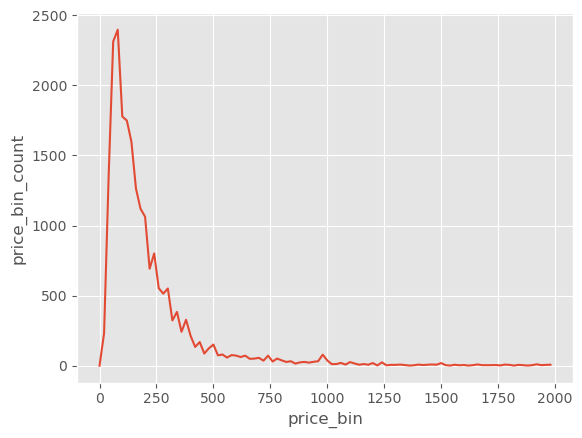

In [28]:
sns.lineplot(x = price_bin_grouping.index, y = 'price_bin_count', data=price_bin_grouping)

<AxesSubplot:xlabel='price_bin', ylabel='availability_365'>

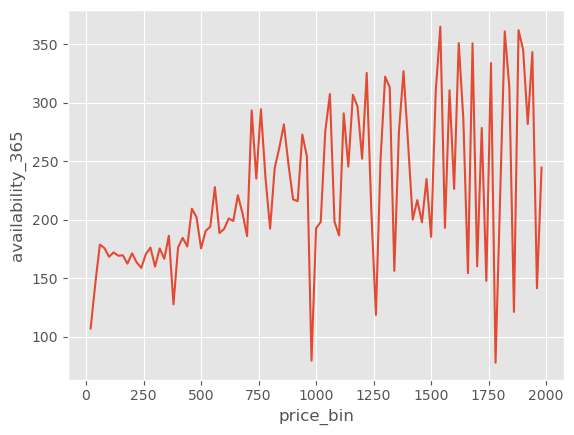

In [29]:
sns.lineplot(x = price_bin_grouping.index, y = 'availability_365', data=price_bin_grouping)

This may show that there may be a market at the 225-250 price bin. This is because there seems to be less availbility in the 250 bin. How much would be needed to justify the increase in price into a new price bin? What can you do as a lister to justify the jump in annual revenue? 

For example what could I do with 2000 that would justify my client paying $20 more per night. 



There is less competition at 250 than at 200 price bin, while also having what seems to be a higher estimated revenue and lower average availablity meaning there is still demand for this price bin. The amount of listing in this criteria may be underserving the demand. 



Text(0, 0.5, 'Average Annual Revenue')

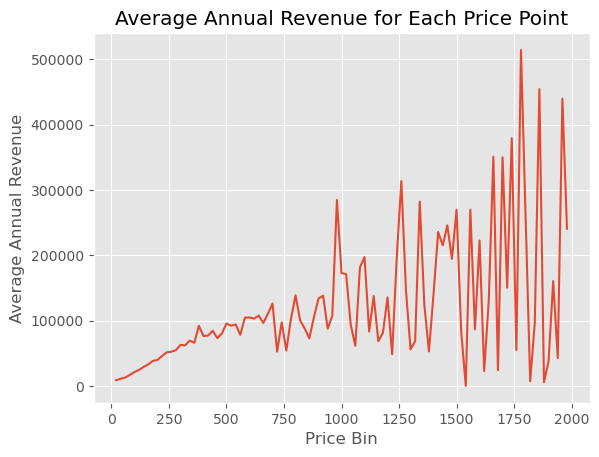

In [30]:
sns.lineplot(x = price_bin_grouping.index, y = 'annual_revenue', data=price_bin_grouping)
plt.title('Average Annual Revenue for Each Price Point')
plt.xlabel('Price Bin')
plt.ylabel('Average Annual Revenue')

Text(0, 0.5, 'Average Reviews Per Month')

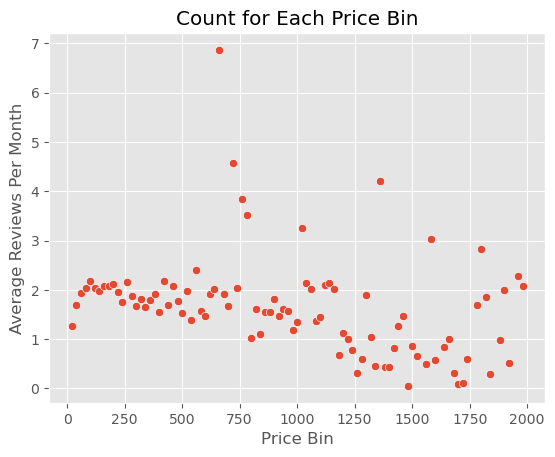

In [31]:
sns.scatterplot(x = price_bin_grouping.index, y = 'reviews_per_month', data=price_bin_grouping)
plt.title('Count for Each Price Bin')
plt.xlabel('Price Bin')
plt.ylabel('Average Reviews Per Month')